In [17]:
import os, math, json, re, time, uuid, random
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import joblib
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# ML libs
from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, brier_score_loss
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from sklearn.utils import check_array

# nflows (install if missing)
try:
    from nflows.flows import Flow
    from nflows.distributions import StandardNormal
    from nflows.transforms import CompositeTransform, MaskedAffineAutoregressiveTransform, ReversePermutation
except Exception:
    raise RuntimeError("nflows is required. Install: pip install nflows")

In [9]:
# ----------------------
# Config & deterministic
# ----------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", DEVICE)

FEATURES = ['u','g','r','i','z','g-r','u-g','r-i','M_r','redshift']

# Quick-run flags (set SUBSET=None to use full data)
SUBSET = 10000        # None or int
QUICK_EPOCHS_A = 20
QUICK_EPOCHS_B = 10
QUICK_EPOCHS_C = 10
USE_QUICK = True      # toggle quick-run

Device: cpu


In [10]:
# ----------------------
# Experiment directories
# ----------------------
ROOT = Path.cwd()
BASE_EXP_ROOT = ROOT / "exp_outputs"
BASE_EXP_ROOT.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_id = uuid.uuid4().hex[:8]
EXP_ROOT = BASE_EXP_ROOT / f"run_{timestamp}_{run_id}"
EXP_ROOT.mkdir(parents=True, exist_ok=True)

print("EXP_ROOT:", EXP_ROOT)

# ----------------------
# Utility functions
# ----------------------
def metrics(y_true, y_pred):
    return {"rmse": math.sqrt(mean_squared_error(y_true, y_pred)),
            "mae": mean_absolute_error(y_true, y_pred),
            "r2": r2_score(y_true, y_pred)}

def fits_to_df_safe(fname, ext=1):
    with fits.open(fname, memmap=True) as hdul:
        data = hdul[ext].data
        names = data.dtype.names
        out = {}
        for n in names:
            col = data[n]
            # convert big-endian
            if getattr(col, "dtype", None) is not None and col.dtype.byteorder in (">", "!"):
                col = col.byteswap().view(col.dtype.newbyteorder("="))
            # handle structured arrays
            try:
                first = col[0]
            except Exception:
                out[n] = col
                continue
            if np.ndim(first) > 0:
                arr = np.vstack(col)
                for j in range(arr.shape[1]):
                    out[f"{n}_{j}"] = arr[:, j]
            else:
                out[n] = col
    return pd.DataFrame(out)

EXP_ROOT: d:\Libraries\Desktop\pinn_v2\exp_outputs\run_20260103_174944_21142808


In [12]:
# ----------------------
# Data load / preprocess
# ----------------------

# ----------------------
# Paths
# ----------------------

EXP_ROOT = Path(EXP_ROOT)  # ensure Path
raw_data_dir = EXP_ROOT / "raw_data"
raw_data_dir.mkdir(parents=True, exist_ok=True)

csv_saved = EXP_ROOT / "mpa_dr7_clean.csv"

# ----------------------
# Load cached CSV if exists
# ----------------------

if csv_saved.exists():
    print("Loading saved cleaned CSV:", csv_saved)
    df_final = pd.read_csv(csv_saved)

else:
    # ----------------------
    # Download FITS files (to EXP_ROOT/raw_data)
    # ----------------------

    base = "https://wwwmpa.mpa-garching.mpg.de/SDSS/DR7/Data"
    files = {
        "gal_info": "gal_info_dr7_v5_2.fit.gz",
        "gal_sfr":  "gal_totsfr_dr7_v5_2.fits.gz",
        "gal_mass": "totlgm_dr7_v5_2.fit.gz"
    }

    local_files = {}

    for name, fn in files.items():
        local_path = raw_data_dir / fn
        local_files[name] = local_path

        if not local_path.exists():
            url = f"{base}/{fn}"
            print(f"Downloading {fn} → {local_path}")
            os.system(f"wget -q {url} -O {local_path}")
        else:
            print("Exists:", local_path)

    # ----------------------
    # Load FITS → DataFrames
    # ----------------------

    df_info = fits_to_df_safe(local_files["gal_info"])
    df_sfr  = fits_to_df_safe(local_files["gal_sfr"])
    df_mass = fits_to_df_safe(local_files["gal_mass"])

    # Prefix to avoid column collisions
    df = pd.concat(
        [
            df_info,
            df_sfr.add_prefix("SFR_"),
            df_mass.add_prefix("MASS_")
        ],
        axis=1
    )

    print("Raw rows:", len(df))

    # ----------------------
    # Required column mapping
    # ----------------------

    required_mapping = {
        'u': 'PLUG_MAG_0',
        'g': 'PLUG_MAG_1',
        'r': 'PLUG_MAG_2',
        'i': 'PLUG_MAG_3',
        'z': 'PLUG_MAG_4',
        'redshift': 'Z',
        'logM_true': 'MASS_MEDIAN',
        'logSFR_true': 'SFR_AVG'
    }

    dfc = df.copy()

    for out_col, src in required_mapping.items():
        if src in dfc.columns:
            series = dfc[src]

            if series.dtype == object:
                def scalarize(x):
                    try:
                        if hasattr(x, '__len__') and not isinstance(x, (str, bytes)):
                            return float(x[0])
                        return float(x)
                    except Exception:
                        return np.nan

                dfc[out_col] = series.map(scalarize)
            else:
                dfc[out_col] = pd.to_numeric(series, errors='coerce')
        else:
            dfc[out_col] = np.nan

    # ----------------------
    # Derived colors
    # ----------------------

    dfc['g-r'] = dfc['g'] - dfc['r']
    dfc['u-g'] = dfc['u'] - dfc['g']
    dfc['r-i'] = dfc['r'] - dfc['i']

    # ----------------------
    # Absolute magnitude M_r
    # ----------------------

    z_valid = (
        dfc['redshift'].notna() &
        (dfc['redshift'] > 0) &
        (dfc['redshift'] < 1.0)
    )

    dl_pc = np.full(len(dfc), np.nan)

    if z_valid.sum() > 0:
        dl_pc_vals = cosmo.luminosity_distance(
            dfc.loc[z_valid, 'redshift']
        ).to('pc').value
        dl_pc[z_valid] = dl_pc_vals

    dfc['M_r'] = np.nan
    mask = (~np.isnan(dl_pc)) & (dl_pc > 0) & dfc['r'].notna()
    dfc.loc[mask, 'M_r'] = dfc.loc[mask, 'r'] - 5*np.log10(dl_pc[mask]) + 5

    # ----------------------
    # Sentinel + numeric cleaning
    # ----------------------

    for b in ['u', 'g', 'r', 'i', 'z']:
        if b in dfc.columns:
            dfc.loc[dfc[b] <= -100, b] = np.nan
            dfc.loc[dfc[b] < -50, b] = np.nan

    dfc = dfc.replace([np.inf, -np.inf], np.nan)

    dfc['logM_true'] = pd.to_numeric(dfc['logM_true'], errors='coerce')
    dfc['logSFR_true'] = pd.to_numeric(dfc['logSFR_true'], errors='coerce')

    # Physical bounds
    dfc = dfc[(dfc['logM_true'] >= 5) & (dfc['logM_true'] <= 13)]
    dfc = dfc[(dfc['logSFR_true'] >= -5) & (dfc['logSFR_true'] <= 2)]

    # ----------------------
    # Final selection
    # ----------------------

    essential = [
        'u','g','r','i','z',
        'g-r','u-g','r-i',
        'M_r','redshift',
        'logM_true','logSFR_true'
    ]

    df_final = (
        dfc
        .dropna(subset=essential)
        .reset_index(drop=True)
    )

    csv_saved.parent.mkdir(parents=True, exist_ok=True)
    df_final.to_csv(csv_saved, index=False)

    print("Saved cleaned CSV:", csv_saved)

FileNotFoundError: [Errno 2] No such file or directory: 'd:\\Libraries\\Desktop\\pinn_v2\\exp_outputs\\run_20260103_174944_21142808\\raw_data\\gal_info_dr7_v5_2.fit.gz'

In [15]:
# Merge exactly as in preprocessing
df_raw = pd.read_csv("mpa_dr7_raw_merged.csv")

print("Raw dataset shape:", df_raw.shape)
df_raw.head()

Raw dataset shape: (927552, 57)


,PLATEID,MJD,FIBERID,PHOTOID_0,PHOTOID_1,PHOTOID_2,PHOTOID_3,PHOTOID_4,RA,DEC,...,SFR_P2P5,SFR_P84,SFR_P97P5,MASS_MEDIAN,MASS_P16,MASS_P84,MASS_P2P5,MASS_P97P5,MASS_MODE,MASS_AVG
0,266,51602,1,756,1,1,206,129,146.71420,-1.041304,...,-1.800000,-0.103459,0.363235,10.294701,10.202774,10.389574,10.124110,10.476275,10.293333,10.308453
1,266,51602,2,756,1,1,208,235,146.91945,-0.990492,...,-1.630000,0.736875,1.198334,11.162018,11.042439,11.284745,10.943877,11.420699,11.226666,11.176508
2,266,51602,4,752,1,2,22,228,146.85983,-0.808902,...,-2.402941,-0.077523,0.413793,11.373624,11.298348,11.466687,11.231741,11.550502,11.389999,11.391095
3,266,51602,5,752,1,2,21,293,146.76340,-0.810433,...,-99.000000,-99.000000,-99.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,266,51602,6,756,1,2,208,268,146.96390,-0.545003,...,-1.075000,0.028417,0.448718,9.958836,9.864179,10.059154,9.768107,10.156217,9.943334,9.972836


In [16]:
features_raw = [
    'PLUG_MAG_0','PLUG_MAG_1','PLUG_MAG_2',
    'PLUG_MAG_3','PLUG_MAG_4',
    'MASS_MEDIAN','SFR_AVG'
]

df_raw_sel = df_raw[features_raw].copy()

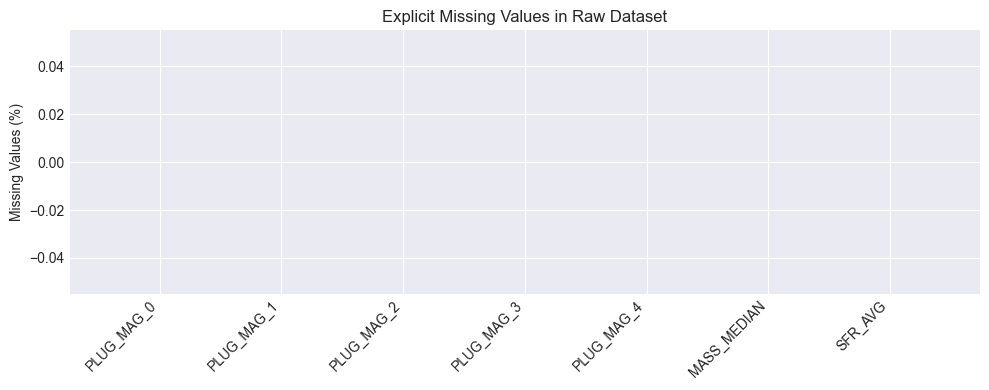

In [18]:
missing_pct = df_raw_sel.isna().mean() * 100

plt.figure(figsize=(10,4))
plt.bar(missing_pct.index, missing_pct.values, color="#1f77b4")
plt.ylabel("Missing Values (%)")
plt.title("Explicit Missing Values in Raw Dataset")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------
# Arrays & splits
# ----------------------
X = df_final[FEATURES].values.astype(np.float32)
yM = df_final['logM_true'].values.astype(np.float32)
yS = df_final['logSFR_true'].values.astype(np.float32)

idx_all = np.arange(len(X))
idx_temp, idx_test = train_test_split(idx_all, test_size=0.20, random_state=SEED)
idx_train, idx_val = train_test_split(idx_temp, test_size=0.20, random_state=SEED)

X_train, X_val, X_test = X[idx_train], X[idx_val], X[idx_test]
yM_train, yM_val, yM_test = yM[idx_train], yM[idx_val], yM[idx_test]
yS_train, yS_val, yS_test = yS[idx_train], yS[idx_val], yS[idx_test]

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

joblib.dump(scaler, os.path.join(EXP_ROOT, "scaler.joblib"))
print("Shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)

In [ ]:
# ----------------------
# Quick-run subset override (safe)
# ----------------------
if USE_QUICK and (SUBSET is not None):
    sel = np.random.RandomState(SEED).choice(np.arange(len(X_train_s)), size=min(SUBSET, len(X_train_s)), replace=False)
    X_train_s = X_train_s[sel]
    yM_train = yM_train[sel]
    yS_train = yS_train[sel]
    print("Quick-run active. Train subset size:", X_train_s.shape[0])

In [ ]:
# %% 
# Cell 5 (REPLACEMENT) — robust priors with GMM clustering & RANSAC (works with subset helper)
np.random.seed(SEED)

# --- Determine active training feature matrix in original (unscaled) units ---
# We want X_train_unscaled to line up with yM_train length (handles subset scenario).
if 'X_train' in globals() and X_train.shape[0] == yM_train.shape[0]:
    X_train_unscaled = X_train
elif 'X_train_s' in globals() and X_train_s.shape[0] == yM_train.shape[0] and 'scaler' in globals() and scaler is not None:
    # inverse transform the scaled subset back to original units
    X_train_unscaled = scaler.inverse_transform(X_train_s)
elif 'X' in globals() and 'idx_train' in globals():
    # fallback: select rows from full X by idx_train (useable when subset helper wasn't used)
    X_train_unscaled = X[np.array(idx_train)]
    if X_train_unscaled.shape[0] != yM_train.shape[0]:
        raise RuntimeError("Fallback selection produced mismatched sizes. Re-run data split (Cell 4).")
else:
    raise RuntimeError("Cannot infer training feature matrix matching yM_train length. Re-run Cell 4 or ensure subset helper didn't partially mutate arrays.")

print("GMM / priors will be computed on training rows:", X_train_unscaled.shape[0])

# --- GMM on (logM, logSFR) using the active training targets ---
XY_train = np.vstack([yM_train, yS_train]).T
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=SEED)
gmm.fit(XY_train)
labels = gmm.predict(XY_train)
comp_means = [XY_train[labels==c,1].mean() if (labels==c).sum()>0 else -1e9 for c in [0,1]]
sf_label = int(np.argmax(comp_means))
print("GMM component mean logSFRs:", comp_means, "-> SF label:", sf_label)

# prepare cluster dictionary
clusters = {}
for comp in [0,1]:
    mask_comp = (labels == comp)
    n_comp = int(mask_comp.sum())
    # if component too small, fall back to full train (avoid unstable fits)
    if n_comp < 10:
        idx_comp_mask = np.ones(len(yM_train), dtype=bool)
        print(f"Warning: cluster {comp} too small ({n_comp}). Falling back to full train.")
    else:
        idx_comp_mask = mask_comp

    pred_cols = ['g-r', 'u-g', 'M_r', 'redshift']
    # build design Xp from X_train_unscaled aligned with yM_train ordering
    Xp = np.vstack([X_train_unscaled[idx_comp_mask, FEATURES.index(c)] for c in pred_cols]).T
    y_comp_mass = yM_train[idx_comp_mask]

    # robust RANSAC fit for mass multi-linear prior
    base_lr = LinearRegression()
    ransac = RANSACRegressor(estimator=base_lr, min_samples=0.5, residual_threshold=1.0, random_state=SEED)
    ransac.fit(Xp, y_comp_mass)
    coef = ransac.estimator_.coef_.astype(float)
    intercept = float(ransac.estimator_.intercept_)

    # MS prior: logSFR ~ A + B * logM  (robust via RANSAC)
    Xm = yM_train[idx_comp_mask].reshape(-1,1)
    ys_comp = yS_train[idx_comp_mask]
    ransac_ms = RANSACRegressor(estimator=LinearRegression(), min_samples=0.5, residual_threshold=0.5, random_state=SEED)
    ransac_ms.fit(Xm, ys_comp)
    A = float(ransac_ms.estimator_.intercept_)
    B = float(ransac_ms.estimator_.coef_[0])

    clusters[f"cluster_{comp}"] = {
        "n_train": int(n_comp),
        "mass_multi": {"intercept": intercept, "coeffs": dict(zip(pred_cols, coef.tolist())), "predictor_order": pred_cols},
        "MS": {"A": A, "B": B}
    }

# --- Compatibility 2-term prior on the currently active training set (g-r, M_r) ---
X2 = np.vstack([
    X_train_unscaled[:, FEATURES.index('g-r')],
    X_train_unscaled[:, FEATURES.index('M_r')]
]).T
lr2 = LinearRegression().fit(X2, yM_train)
a2 = float(lr2.intercept_)
# coef_ may be 1d length-2
b2, c2 = float(lr2.coef_[0]), float(lr2.coef_[1])
print("Compatibility 2-term prior fitted on rows:", X_train_unscaled.shape[0], "a2,b2,c2:", a2, b2, c2)

# --- Overall robust prior on whole (active) training set using RANSAC too ---
def fit_mass_prior_robust(X_unscaled, y_arr):
    pred_cols = ['g-r','u-g','M_r','redshift']
    X_train_mass = np.vstack([X_unscaled[:, FEATURES.index(c)] for c in pred_cols]).T
    y_train_mass = y_arr
    base_lr = LinearRegression()
    ransac = RANSACRegressor(estimator=base_lr, min_samples=0.5, residual_threshold=1.0, random_state=SEED)
    ransac.fit(X_train_mass, y_train_mass)
    coef = ransac.estimator_.coef_.astype(float)
    intercept = float(ransac.estimator_.intercept_)
    return intercept, dict(zip(pred_cols, coef.tolist())), pred_cols

intercept_all, coeffs_all, pred_order_all = fit_mass_prior_robust(X_train_unscaled, yM_train)

# average MS A,B across clusters (safe if both clusters present)
A_all = float((clusters['cluster_0']['MS']['A'] + clusters['cluster_1']['MS']['A'])/2.0)
B_all = float((clusters['cluster_0']['MS']['B'] + clusters['cluster_1']['MS']['B'])/2.0)

priors = {
    "clusters": clusters,
    "mass_multi": {"intercept": intercept_all, "coeffs": coeffs_all, "predictor_order": pred_order_all, "n_train": int(X_train_unscaled.shape[0])},
    "a": a2, "b": float(b2), "c": float(c2),
    "MS_overall": {"A": A_all, "B": B_all},
}

# save
os.makedirs(EXP_ROOT, exist_ok=True)
with open(os.path.join(EXP_ROOT, "priors.json"), "w") as f:
    json.dump(priors, f, indent=2)

print("Saved clustered priors. cluster sizes (train):", {k: v['n_train'] for k, v in clusters.items()})
print("Saved priors.json to", os.path.join(EXP_ROOT, "priors.json"))


In [ ]:
# ----------------------
# Cell 6 — Baseline RFs
# ----------------------
rf_params = dict(n_estimators=50, max_depth=20, n_jobs=1, random_state=SEED)
print("Training RF with params:", rf_params)
rf_m = RandomForestRegressor(**rf_params)
rf_s = RandomForestRegressor(**rf_params)
t0 = time.time()
rf_m.fit(X_train_s, yM_train)
rf_s.fit(X_train_s, yS_train)
t_rf = time.time() - t0
print("RF training time (s):", t_rf)
m_rf_pred = rf_m.predict(X_test_s)
s_rf_pred = rf_s.predict(X_test_s)
print("RF mass metrics:", metrics(yM_test, m_rf_pred))
print("RF sfr metrics:", metrics(yS_test, s_rf_pred))
joblib.dump(rf_m, os.path.join(EXP_ROOT, "rf_mass.joblib"))
joblib.dump(rf_s, os.path.join(EXP_ROOT, "rf_sfr.joblib"))

In [ ]:
# ----------------------
# Stage A — deterministic multitask PINN (pretrain)
# ----------------------
class MTNN_det(nn.Module):
    """
    Stage A: Deterministic Physics-Informed Neural Network
    Predicts physically bounded logM and logSFR
    """
    def __init__(self, dim):
        super().__init__()

        # Shared encoder
        self.shared = nn.Sequential(
            nn.Linear(dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        # Raw heads (bounded via tanh)
        self.m_head = nn.Sequential(
            nn.Linear(128, 1),
            nn.Tanh()
        )
        self.s_head = nn.Sequential(
            nn.Linear(128, 1),
            nn.Tanh()
        )

        # Physical bounds
        # logM ∈ [5, 13] → center=9, half-range=4
        self.M_CENTER = 9.0
        self.M_SCALE  = 4.0

        # logSFR ∈ [-5, 2] → center=-1.5, half-range=3.5
        self.S_CENTER = -1.5
        self.S_SCALE  = 3.5

    def forward(self, x):
        h = self.shared(x)

        # Raw bounded outputs in (-1, 1)
        m_raw = self.m_head(h).squeeze(-1)
        s_raw = self.s_head(h).squeeze(-1)

        # Rescale to physical ranges
        m_mu = self.M_CENTER + self.M_SCALE * m_raw
        s_mu = self.S_CENTER + self.S_SCALE * s_raw

        return m_mu, s_mu

batch_A = 512
train_ds = TensorDataset(torch.tensor(X_train_s, dtype=torch.float32),
                         torch.tensor(yM_train, dtype=torch.float32),
                         torch.tensor(yS_train, dtype=torch.float32))
val_ds = TensorDataset(torch.tensor(X_val_s, dtype=torch.float32),
                       torch.tensor(yM_val, dtype=torch.float32),
                       torch.tensor(yS_val, dtype=torch.float32))
train_loader = DataLoader(train_ds, batch_size=batch_A, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1024, shuffle=False)

modelA = MTNN_det(X_train_s.shape[1]).to(DEVICE)
optA = Adam(modelA.parameters(), lr=5e-4, weight_decay=1e-6)
epochsA = QUICK_EPOCHS_A if USE_QUICK else 50
clip_norm = 5.0

# load priors
with open(os.path.join(EXP_ROOT, "priors.json"), "r") as f:
    pri = json.load(f)
pri_a = float(pri.get('a', 0.0)); pri_b = float(pri.get('b', 0.0)); pri_c = float(pri.get('c', 0.0))
pri_A = float(pri.get('MS_overall', {}).get('A', 0.0)); pri_B = float(pri.get('MS_overall', {}).get('B', 0.0))
LAMBDA_MASS = 0.02; LAMBDA_MS = 0.02

mse_loss = nn.MSELoss()
best_val = 1e12; best_stateA = None
for epoch in range(1, epochsA+1):
    modelA.train()
    losses = []
    for Xb, ym, ys in train_loader:
        Xb = Xb.to(DEVICE); ym = ym.to(DEVICE); ys = ys.to(DEVICE)
        m_p, s_p = modelA(Xb)
        L_data = mse_loss(m_p, ym) + mse_loss(s_p, ys)
        # mass prior computed on original scale
        Xb_un = scaler.inverse_transform(Xb.cpu().numpy())
        mass_prior = pri_a + pri_b * Xb_un[:, FEATURES.index('g-r')] + pri_c * Xb_un[:, FEATURES.index('M_r')]
        mass_prior_t = torch.tensor(mass_prior, dtype=torch.float32, device=DEVICE)
        L_mass = mse_loss(m_p, mass_prior_t)
        L_MS = mse_loss(s_p, pri_A + pri_B * m_p.detach())
        L_total = L_data + LAMBDA_MASS * L_mass + LAMBDA_MS * L_MS
        optA.zero_grad(); L_total.backward()
        torch.nn.utils.clip_grad_norm_(modelA.parameters(), clip_norm)
        optA.step()
        losses.append(float(L_total.detach().cpu().numpy()))
    # val
    modelA.eval()
    with torch.no_grad():
        preds = []; trues = []
        for Xb, ym, ys in val_loader:
            Xb = Xb.to(DEVICE)
            m_p, s_p = modelA(Xb)
            preds.append(m_p.cpu().numpy()); trues.append(ym.numpy())
    val_mse = mean_squared_error(np.concatenate(trues), np.concatenate(preds))
    if val_mse < best_val:
        best_val = val_mse
        best_stateA = {k:v.cpu() for k,v in modelA.state_dict().items()}
    if epoch % 5 == 0 or epoch == 1:
        print(f"[Stage A] Epoch {epoch:03d} train_loss={np.mean(losses):.6f} val_mse={val_mse:.6f}")

torch.save(best_stateA, os.path.join(EXP_ROOT,"pinn_stageA_best.pth"))
print("Saved Stage A best.")

# Build Context wrapper from Stage A (only if Stage A actually trained)
class ContextNetWrapper(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(dim,256), nn.ReLU(),
            nn.Linear(256,128), nn.ReLU()
        )
        self.context_net = nn.Sequential(
            nn.Linear(128,64), nn.ReLU(),
            nn.Linear(64,64), nn.ReLU()
        )
    def forward(self, x):
        return self.context_net(self.encoder(x))

ctx_model = ContextNetWrapper(X_train_s.shape[1]).to(DEVICE)

if best_stateA is not None:
    # Map weights from modelA.shared -> ctx_model.encoder
    sdA = best_stateA
    mapping = {
        'encoder.0.weight':'shared.0.weight',
        'encoder.0.bias':'shared.0.bias',
        'encoder.2.weight':'shared.2.weight',
        'encoder.2.bias':'shared.2.bias'
    }
    sd_ctx = ctx_model.state_dict()
    for t_key, s_key in mapping.items():
        if s_key in sdA and t_key in sd_ctx:
            sd_ctx[t_key] = sdA[s_key]
    ctx_model.load_state_dict(sd_ctx)
    for p in ctx_model.parameters():
        p.requires_grad = False
    print("Context model prepared from Stage A weights (frozen).")
else:
    # Stage A was skipped; leave context model randomly initialized
    print("Stage A skipped; context model initialized randomly.")

In [ ]:
# ===== Stage A evaluation ONLY =====
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

modelA.eval()
with torch.no_grad():
    X_t = torch.tensor(X_test_s, dtype=torch.float32).to(DEVICE)
    m_mu, s_mu = modelA(X_t)

mu_m = m_mu.cpu().numpy()
mu_s = s_mu.cpu().numpy()

def metrics(y_true, y_pred):
    return {
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }

print("Stage A mass metrics:", metrics(yM_test, mu_m))
print("Stage A sfr metrics :", metrics(yS_test, mu_s))
print("mu_m range:", mu_m.min(), mu_m.max())
print("mu_s range:", mu_s.min(), mu_s.max())


In [ ]:
# ----------------------
# Stage B — flow-only training (conditional flow for Q)
# ----------------------

def build_conditional_maf(context_dim, n_blocks=4, hidden_features=64):
    transforms = []
    for _ in range(n_blocks):
        transforms.append(
            MaskedAffineAutoregressiveTransform(
                features=1,
                hidden_features=hidden_features,
                context_features=context_dim,
                num_blocks=2,
                use_residual_blocks=False
            )
        )
        transforms.append(ReversePermutation(features=1))
    transform = CompositeTransform(transforms)
    base_dist = StandardNormal([1])
    return Flow(transform, base_dist)


# ---- Instantiate flow ----
context_dim = 64
flow = build_conditional_maf(
    context_dim=context_dim,
    n_blocks=4,
    hidden_features=64
).to(DEVICE)

opt_flow = Adam(flow.parameters(), lr=3e-4, weight_decay=1e-6)
epochsB = QUICK_EPOCHS_B if USE_QUICK else 40

# ---- Identify quenched component from GMM (fit earlier on train) ----
comp_means_sfr = gmm.means_[:, 1]
quenched_comp = int(np.argmin(comp_means_sfr))
print("GMM train means (logSFR):", comp_means_sfr, "-> quenched:", quenched_comp)

train_loader_flow = DataLoader(train_ds, batch_size=256, shuffle=True)

best_flow_state = None
best_flow_loss = float("inf")

# ----------------------
# Training loop
# ----------------------
for epoch in range(1, epochsB + 1):
    flow.train()
    losses = []

    for Xb, ym, ys in train_loader_flow:
        Xb = Xb.to(DEVICE).float()

        # ---- Context from frozen encoder ----
        with torch.no_grad():
            ctx = ctx_model(Xb)
        ctx = ctx.detach()  # 🔒 critical: prevent any leakage / gradients

        # ---- Soft quenching target from GMM ----
        ym_np = ym.numpy()
        ys_np = ys.numpy()
        q_target = gmm.predict_proba(
            np.vstack([ym_np, ys_np]).T
        )[:, quenched_comp].astype(np.float32)

        q_t = torch.tensor(q_target, device=DEVICE).unsqueeze(-1)

        # ---- Flow NLL ----
        nll = -flow.log_prob(q_t, context=ctx).mean()

        opt_flow.zero_grad()
        nll.backward()
        torch.nn.utils.clip_grad_norm_(flow.parameters(), 5.0)
        opt_flow.step()

        losses.append(float(nll.detach().cpu()))

    avg_nll = float(np.mean(losses))
    if avg_nll < best_flow_loss:
        best_flow_loss = avg_nll
        best_flow_state = {k: v.cpu() for k, v in flow.state_dict().items()}

    if epoch % 5 == 0 or epoch == 1:
        print(f"[Stage B] Epoch {epoch:03d} flow_nll={avg_nll:.6f}")

# ----------------------
# Save best flow
# ----------------------
if best_flow_state is not None:
    torch.save(
        best_flow_state,
        os.path.join(EXP_ROOT, "pinn_flow_stageB_flow.pth")
    )
    print("Saved Stage B flow.")


In [ ]:
# %% Cell 7C — Stage C: Joint fine-tune (bounded, safe, copy-paste ready)
import os, math, json, numpy as np, random, torch, torch.nn as nn
from torch.optim import Adam
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error

# Deterministic seed
np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Stage C running on device:", DEVICE)

# --- Fallback: ensure loaders exist ---
from torch.utils.data import DataLoader, TensorDataset
if 'train_loader' not in globals() or 'val_loader' not in globals():
    print("Fallback: creating train/val DataLoaders from arrays.")
    batch_train = globals().get('BATCH_TRAIN', 512)
    batch_val = globals().get('BATCH_VAL', 1024)
    train_ds = TensorDataset(torch.tensor(X_train_s,dtype=torch.float32),
                             torch.tensor(yM_train,dtype=torch.float32),
                             torch.tensor(yS_train,dtype=torch.float32))
    val_ds = TensorDataset(torch.tensor(X_val_s,dtype=torch.float32),
                           torch.tensor(yM_val,dtype=torch.float32),
                           torch.tensor(yS_val,dtype=torch.float32))
    train_loader = DataLoader(train_ds, batch_size=batch_train, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_val, shuffle=False)
    print("Created fallback loaders. Train size:", len(train_ds), "Val size:", len(val_ds))

# ----------------------
# Joint model (BOUNDED means)
# ----------------------
class PINNJoint(nn.Module):
    def __init__(self, dim, context_dim=64):
        super().__init__()

        # Shared encoder (same as Stage A)
        self.shared = nn.Sequential(
            nn.Linear(dim,256), nn.ReLU(),
            nn.Linear(256,128), nn.ReLU()
        )

        # Raw bounded heads
        self.m_head = nn.Sequential(nn.Linear(128,1), nn.Tanh())
        self.s_head = nn.Sequential(nn.Linear(128,1), nn.Tanh())

        # Heteroscedastic log-variance heads
        self.m_logvar = nn.Linear(128,1)
        self.s_logvar = nn.Linear(128,1)

        # Context net for flow
        self.context_net = nn.Sequential(
            nn.Linear(128,context_dim), nn.ReLU(),
            nn.Linear(context_dim,context_dim), nn.ReLU()
        )

        # Physical bounds (same as Stage A)
        # logM ∈ [5, 13]
        self.M_CENTER = 9.0
        self.M_SCALE  = 4.0
        # logSFR ∈ [-5, 2]
        self.S_CENTER = -1.5
        self.S_SCALE  = 3.5

        self.context_dim = context_dim
        self.flow = None

    def forward(self, x):
        h = self.shared(x)

        # bounded means
        m_raw = self.m_head(h).squeeze(-1)
        s_raw = self.s_head(h).squeeze(-1)

        m_mu = self.M_CENTER + self.M_SCALE * m_raw
        s_mu = self.S_CENTER + self.S_SCALE * s_raw

        # log-variances
        m_logvar = self.m_logvar(h).squeeze(-1)
        s_logvar = self.s_logvar(h).squeeze(-1)

        ctx = self.context_net(h)

        return {
            "context": ctx,
            "mu_mass": m_mu,
            "logvar_mass": m_logvar,
            "mu_sfr": s_mu,
            "logvar_sfr": s_logvar
        }

# ----------------------
# Flow builder
# ----------------------
def build_conditional_maf(context_dim, n_blocks=6, hidden_features=128):
    from nflows.flows import Flow
    from nflows.distributions import StandardNormal
    from nflows.transforms import CompositeTransform, MaskedAffineAutoregressiveTransform, ReversePermutation
    transforms = []
    for _ in range(n_blocks):
        transforms.append(MaskedAffineAutoregressiveTransform(
            features=1,
            hidden_features=hidden_features,
            context_features=context_dim,
            num_blocks=2,
            use_residual_blocks=False
        ))
        transforms.append(ReversePermutation(features=1))
    return Flow(CompositeTransform(transforms), StandardNormal([1]))

# ----------------------
# Instantiate joint model
# ----------------------
context_dim = 64
joint = PINNJoint(X_train_s.shape[1], context_dim=context_dim).to(DEVICE)

# --- Load Stage A weights (shared encoder only) ---
p_stageA = os.path.join(EXP_ROOT, "pinn_stageA_best.pth")
if os.path.exists(p_stageA):
    sdA = torch.load(p_stageA, map_location='cpu')
    joint_sd = joint.state_dict()
    copied = 0
    for k,v in sdA.items():
        if k in joint_sd and joint_sd[k].shape == v.shape:
            joint_sd[k].copy_(v)
            copied += 1
    joint.load_state_dict(joint_sd)
    print(f"Loaded Stage A weights (copied {copied} params).")

# --- Load Stage B flow (infer architecture if needed) ---
p_flowB = os.path.join(EXP_ROOT, "pinn_flow_stageB_flow.pth")
flow_loaded = False
if os.path.exists(p_flowB):
    try:
        joint.flow = build_conditional_maf(context_dim, n_blocks=4, hidden_features=64).to(DEVICE)
        joint.flow.load_state_dict(torch.load(p_flowB, map_location='cpu'))
        flow_loaded = True
        print("Loaded Stage B flow.")
    except Exception as e:
        print("Flow load issue:", e)

if not flow_loaded:
    joint.flow = build_conditional_maf(context_dim, n_blocks=4, hidden_features=64).to(DEVICE)
    print("Using randomly initialized flow.")

# ----------------------
# Optimizer & config
# ----------------------
for p in joint.parameters(): p.requires_grad = True
for p in joint.flow.parameters(): p.requires_grad = True

opt = Adam(list(joint.parameters()) + list(joint.flow.parameters()), lr=1e-4, weight_decay=1e-6)
epochsC = globals().get('epochsC', 20)
clip_norm = 5.0

LOGVAR_MIN, LOGVAR_MAX = -10.0, 5.0

def gaussian_nll_torch(y, mu, logvar):
    logvar = torch.clamp(logvar, LOGVAR_MIN, LOGVAR_MAX)
    var = torch.exp(logvar)
    return 0.5 * ((y - mu)**2 / var + logvar + math.log(2*math.pi))

# ----------------------
# Priors & GMM
# ----------------------
with open(os.path.join(EXP_ROOT, "priors.json"), "r") as f:
    pri = json.load(f)

pri_a = float(pri.get('a',0)); pri_b = float(pri.get('b',0)); pri_c = float(pri.get('c',0))
A_all = float(pri.get('MS_overall',{}).get('A',0))
B_all = float(pri.get('MS_overall',{}).get('B',0))

LAMBDA_MASS = 0.02; LAMBDA_MS = 0.02; LAMBDA_Q = 1.0; LAMBDA_Q_PHYS = 0.5

gmm_train = GaussianMixture(n_components=2, covariance_type='full', random_state=SEED)
gmm_train.fit(np.vstack([yM_train, yS_train]).T)
quenched_comp = int(np.argmin(gmm_train.means_[:,1]))

# ----------------------
# Training loop (uncomment to run)
# ----------------------
best_val = 1e12; best_state = None; best_flow_state = None

for epoch in range(1, epochsC+1):
    joint.train(); joint.flow.train()
    losses = []
    for Xb, ym, ys in train_loader:
        Xb = Xb.to(DEVICE); ym = ym.to(DEVICE); ys = ys.to(DEVICE)
        out = joint(Xb)
        ctx = out["context"]
        m_mu = out["mu_mass"]; s_mu = out["mu_sfr"]
        m_lv = torch.clamp(out["logvar_mass"], LOGVAR_MIN, LOGVAR_MAX)
        s_lv = torch.clamp(out["logvar_sfr"], LOGVAR_MIN, LOGVAR_MAX)

        L_data = gaussian_nll_torch(ym, m_mu, m_lv).mean() + gaussian_nll_torch(ys, s_mu, s_lv).mean()

        Xb_un = scaler.inverse_transform(Xb.cpu().numpy())
        mass_prior = pri_a + pri_b*Xb_un[:,FEATURES.index('g-r')] + pri_c*Xb_un[:,FEATURES.index('M_r')]
        L_mass = nn.functional.mse_loss(m_mu, torch.tensor(mass_prior, device=DEVICE))
        L_MS = nn.functional.mse_loss(s_mu, A_all + B_all*m_mu.detach())

        q_t = torch.tensor(
            gmm_train.predict_proba(np.vstack([ym.cpu().numpy(), ys.cpu().numpy()]).T)[:,quenched_comp],
            device=DEVICE
        ).unsqueeze(-1)

        nll_q = -joint.flow.log_prob(q_t, context=ctx.detach()).mean()

        L = L_data + LAMBDA_MASS*L_mass + LAMBDA_MS*L_MS + LAMBDA_Q*nll_q
        opt.zero_grad(); L.backward()
        torch.nn.utils.clip_grad_norm_(list(joint.parameters())+list(joint.flow.parameters()), clip_norm)
        opt.step()
        losses.append(L.item())

    print(f"[Stage C] Epoch {epoch:03d} loss={np.mean(losses):.4f}")

# ----------------------
# Save FINAL Stage C model (REQUIRED)
# ----------------------
torch.save(joint.state_dict(), os.path.join(EXP_ROOT, "pinn_stageC_joint_final.pth"))
torch.save(joint.flow.state_dict(), os.path.join(EXP_ROOT, "pinn_stageC_flow_final.pth"))

print("Saved final Stage C joint model and flow.")


In [ ]:
# %% Final Evaluation — Stage C (memory-safe, paper-ready)

import os, json, math, numpy as np, torch
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    roc_auc_score, brier_score_loss
)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Evaluation running on device:", DEVICE)

# ----------------------
# Load trained Stage C model
# ----------------------
joint.eval()
joint.flow.eval()

# ----------------------
# Helpers
# ----------------------
def metrics(y_true, y_pred):
    return {
        "rmse": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "r2":  float(r2_score(y_true, y_pred))
    }

def gaussian_nll(y, mu, logvar):
    logvar = np.clip(logvar, -10.0, 5.0)
    var = np.exp(logvar)
    return 0.5 * ((y - mu)**2 / var + logvar + np.log(2*np.pi))

# ----------------------
# Batched forward pass
# ----------------------
BATCH_EVAL = 2048
N = len(X_test_s)

mu_m, mu_s = [], []
lv_m, lv_s = [], []
contexts = []

with torch.no_grad():
    for i in range(0, N, BATCH_EVAL):
        xb = torch.tensor(
            X_test_s[i:i+BATCH_EVAL],
            dtype=torch.float32,
            device=DEVICE
        )
        out = joint(xb)

        mu_m.append(out["mu_mass"].cpu().numpy())
        mu_s.append(out["mu_sfr"].cpu().numpy())
        lv_m.append(out["logvar_mass"].cpu().numpy())
        lv_s.append(out["logvar_sfr"].cpu().numpy())
        contexts.append(out["context"].cpu())

mu_m = np.concatenate(mu_m)
mu_s = np.concatenate(mu_s)
lv_m = np.concatenate(lv_m)
lv_s = np.concatenate(lv_s)
contexts = torch.cat(contexts, dim=0)

sig_m = np.sqrt(np.exp(lv_m))
sig_s = np.sqrt(np.exp(lv_s))

# ----------------------
# Regression metrics
# ----------------------
mass_metrics = metrics(yM_test, mu_m)
sfr_metrics  = metrics(yS_test, mu_s)

nll_mass = float(np.mean(gaussian_nll(yM_test, mu_m, lv_m)))
nll_sfr  = float(np.mean(gaussian_nll(yS_test, mu_s, lv_s)))

print("PINN mass metrics:", mass_metrics)
print("PINN sfr metrics :", sfr_metrics)
print("Gaussian NLL mass / sfr:", nll_mass, nll_sfr)

# ----------------------
# Quenching posterior (flow sampling)
# ----------------------
N_SAMPLES_Q = 50   # safe on CPU
q_means = []
q_stds  = []

with torch.no_grad():
    for i in range(0, N, BATCH_EVAL):
        ctx = contexts[i:i+BATCH_EVAL].to(DEVICE)

        # flow returns (S, B, 1)
        qs = joint.flow.sample(N_SAMPLES_Q, context=ctx)
        qs = qs.squeeze(-1).cpu().numpy()   # (S, B)

        # transpose → (B, S)
        qs = qs.T

        q_means.append(qs.mean(axis=1))
        q_stds.append(qs.std(axis=1))

q_mean = np.concatenate(q_means, axis=0)   # (N,)
q_std  = np.concatenate(q_stds, axis=0)    # (N,)


# ----------------------
# Optional classification metrics (if labels exist)
# ----------------------
q_metrics = {}
if "gmm_train" in globals():
    q_true = gmm_train.predict_proba(
        np.vstack([yM_test, yS_test]).T
    )[:, quenched_comp]

    try:
        q_metrics["auc"] = float(roc_auc_score(q_true, q_mean))
        q_metrics["brier"] = float(brier_score_loss(q_true, q_mean))
        print("Q metrics:", q_metrics)
    except Exception as e:
        print("Q metrics skipped:", e)

# ----------------------
# Save evaluation summary
# ----------------------
summary = {
    "mass_metrics": mass_metrics,
    "sfr_metrics": sfr_metrics,
    "nll_mass": nll_mass,
    "nll_sfr": nll_sfr,
    "q_metrics": q_metrics,
    "uncertainty_stats": {
        "sigma_mass_median": float(np.median(sig_m)),
        "sigma_sfr_median":  float(np.median(sig_s)),
        "q_std_median":      float(np.median(q_std))
    }
}

with open(os.path.join(EXP_ROOT, "evaluation.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("Saved evaluation.json to", EXP_ROOT)
print("Evaluation complete.")